In [1]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

configure_plot_style()

In [2]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [3]:
#Load Laos shapefile
laos = load_shapefile('laos')

In [4]:
#Load data
emdat = load_emdat_data()

In [5]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [6]:
world = load_shapefile('world')
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_96396\3914288617.py:4: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


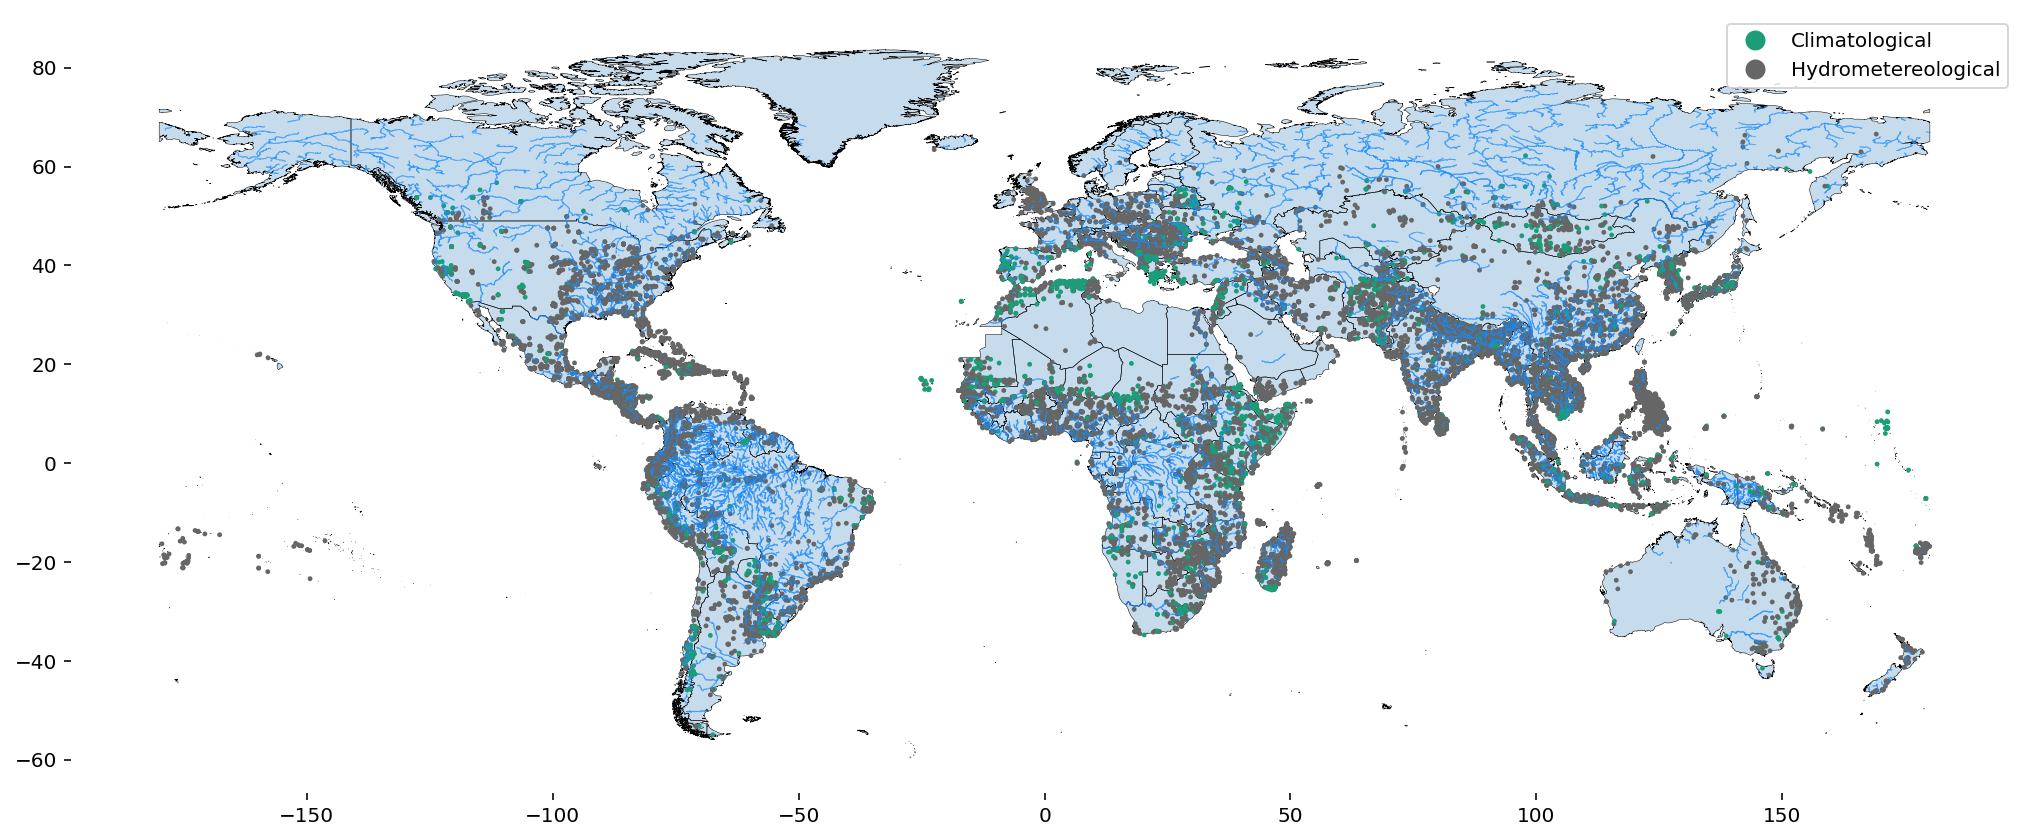

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2');

In [8]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [9]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

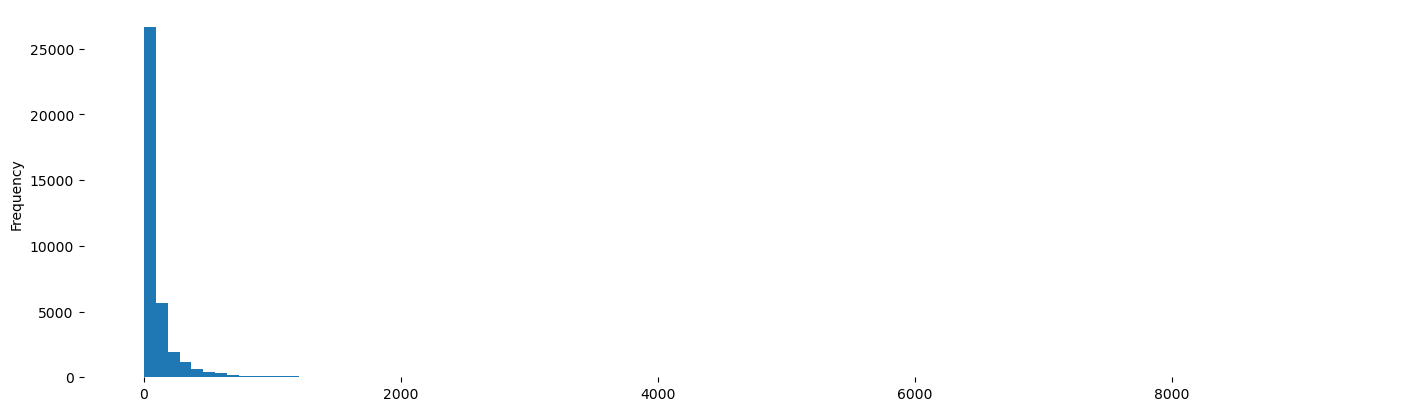

In [10]:
data.distance_to_river.plot.hist(bins=100)

In [11]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

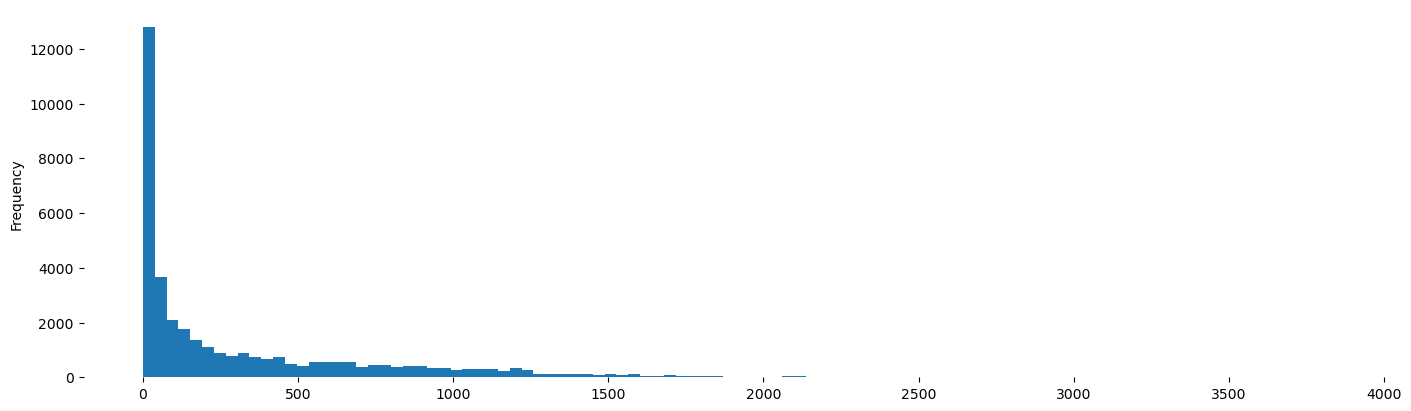

In [12]:
data.distance_to_coastline.plot.hist(bins=100)

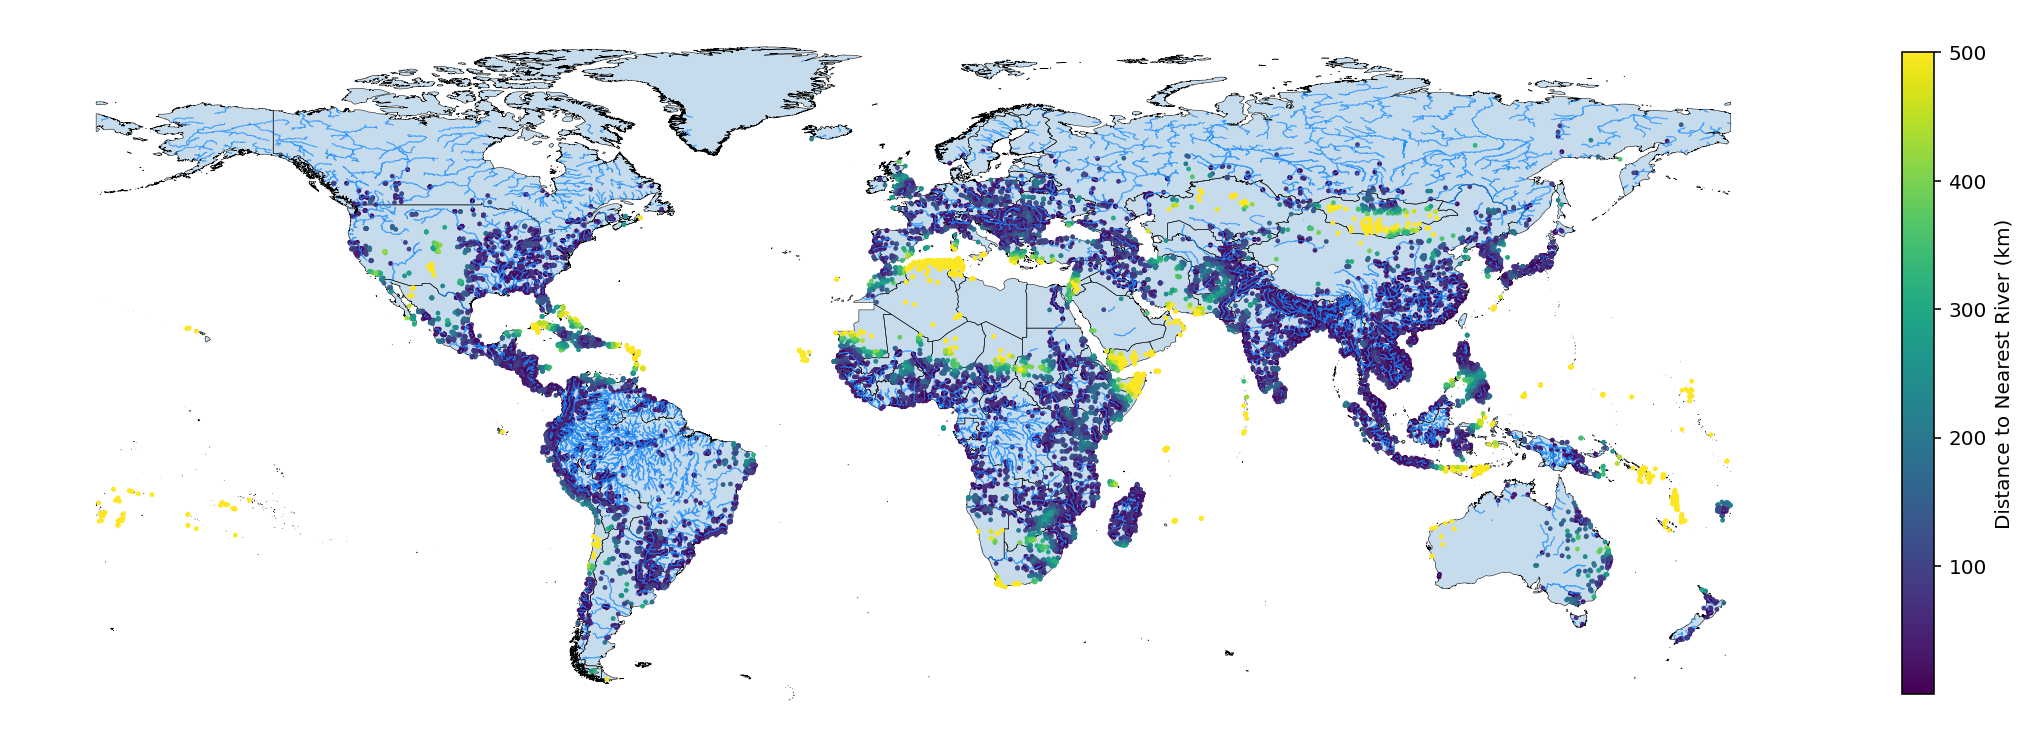

In [13]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

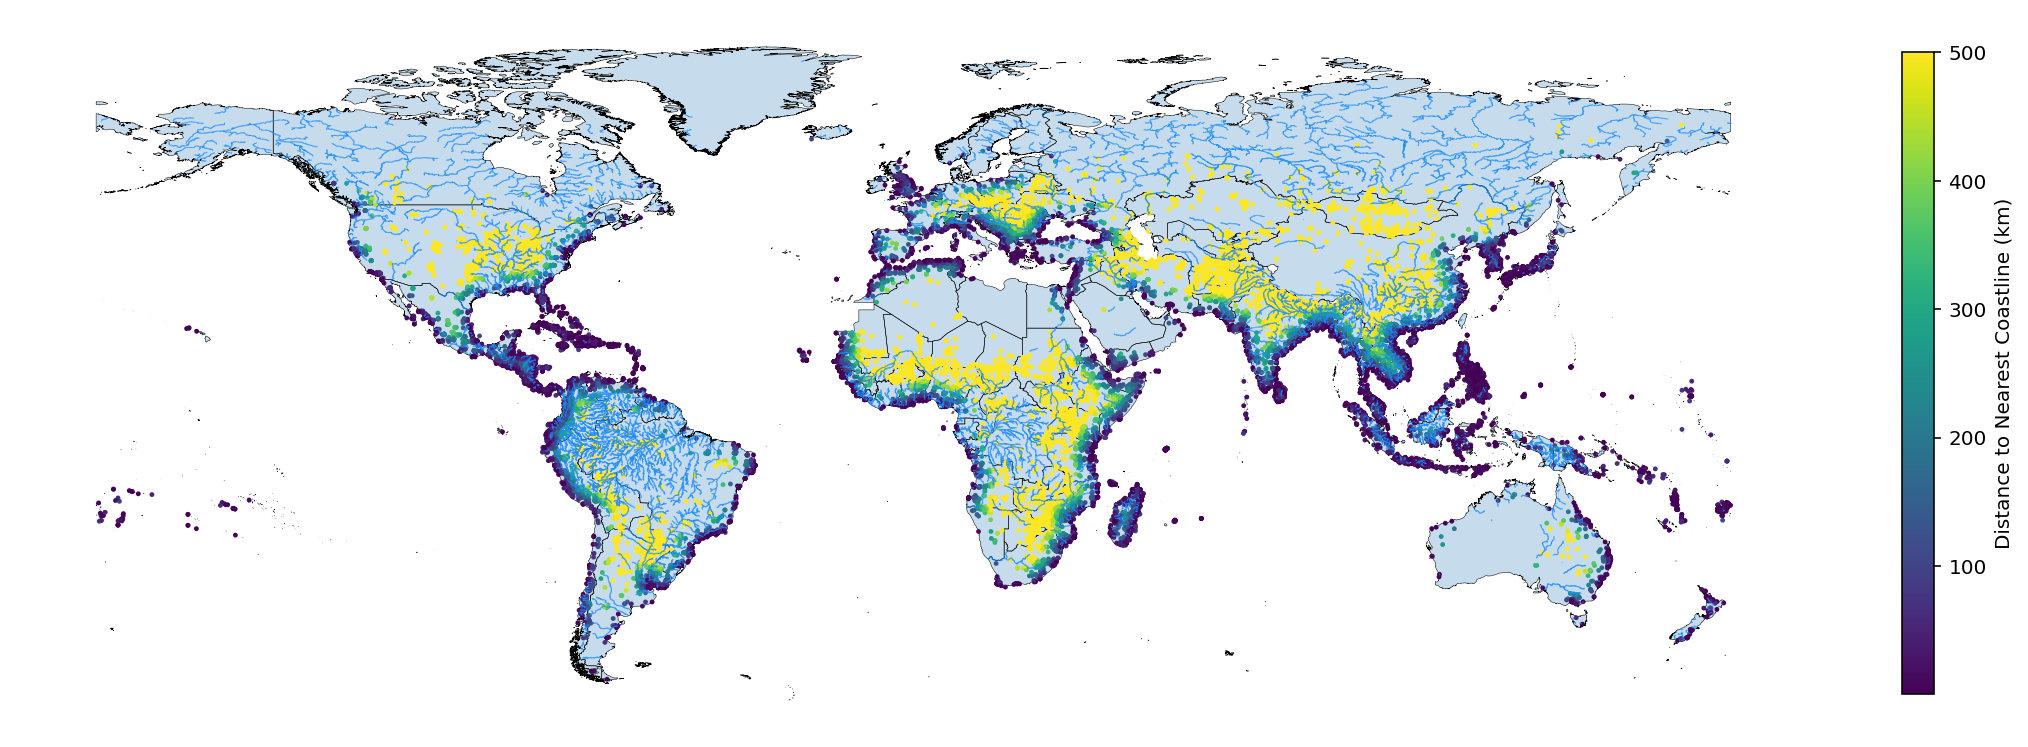

In [14]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [15]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True

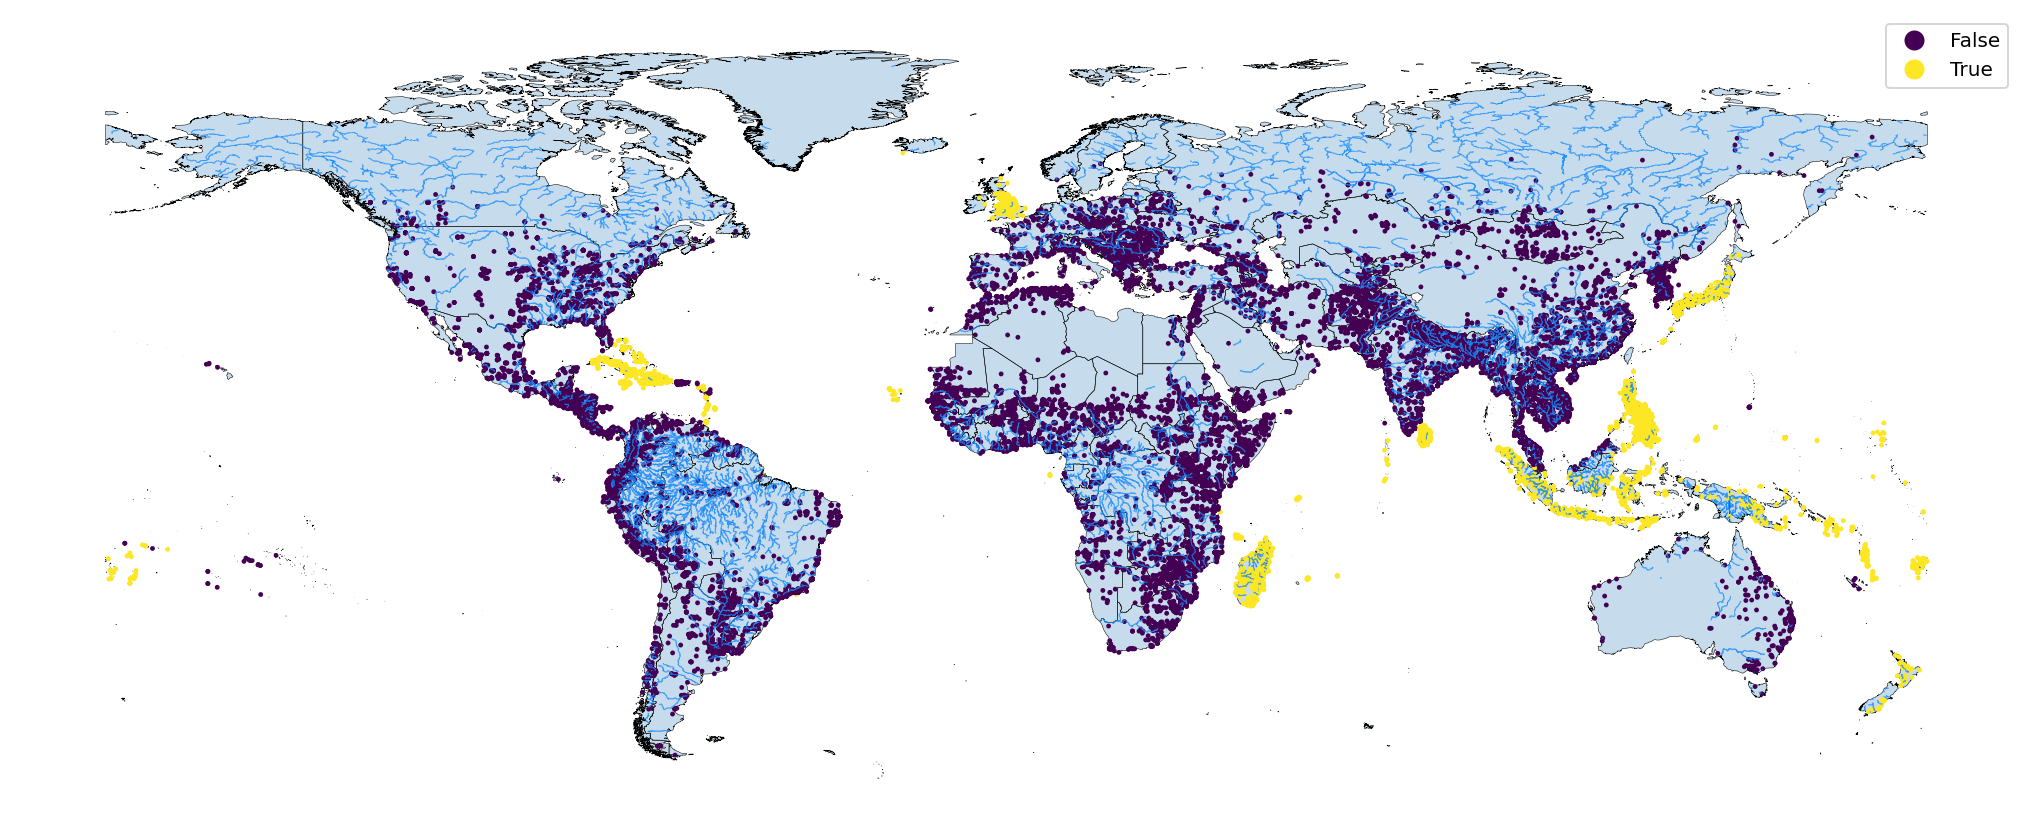

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [17]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [18]:
# Loading the synthetic data by country
not_disasters = pd.read_csv(here('data/synthetic_non_disasters_by_country_long.csv'))
not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# Merging data

In [19]:
#Rename not_disaster columns
not_disasters.rename(columns ={ "twin_emdat_index": "emdat_index",
                              "twin_location_id": "location_id"}, inplace = True)

#Assign rando years to each fake disaster
not_disasters2 = pd.merge(not_disasters, data.groupby("ISO").Start_Year.sample( frac=1.0, replace=False), right_index= True,
         left_on= ["emdat_index", "location_id" ], how = "left" )

In [20]:
#Add the is_real columns
not_disasters2["is_disaster"] = 0
data["is_disaster"] = 1

#Concat data frames
merged_df = pd.concat([not_disasters2, data.reset_index()], ignore_index= True)

In [21]:
#Load data
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density',
       'gdp_per_cap', 'Population', 'precip']]

co2 = all_data["df_time_series"]["co2"]

In [22]:
#Obtain precip_deviation
precipitation = all_data["gpcc"]

countries = precipitation.reset_index()["ISO"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns=countries)
for x in countries:
    precip_deviation[x] = (
        precipitation.reset_index().pivot(
            index="year", values="precip", columns="ISO"
        )[x]
        - pd.DataFrame(precipitation.unstack(-2).head(30).mean())
        .loc["precip"]
        .loc[x]
        .values
    )

precip_deviation = (
    precip_deviation.stack()
    .reset_index()
    .rename(columns={"level_1": "ISO", 0: "precip_deviation"})
    .set_index(["ISO", "year"])
)
precip_deviation = precip_deviation.sort_index()

In [23]:
#Obtain ocean temperature deviation
from statsmodels.tsa.seasonal import STL

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1]

stl_ocean_temp = STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

dev_from_trend_ocean_temp = pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_ocean_temp"})

In [24]:
#Merge Data Frames
merged_df2 = pd.merge(merged_df, panel_data, left_on= ["ISO", "Start_Year"], right_index= True, how = "left")
merged_df3 = pd.merge(merged_df2, co2, left_on= ["Start_Year"], right_index= True, how = "left")
merged_df4 = pd.merge(merged_df3, precip_deviation, left_on= ["ISO", "Start_Year"], right_index= True, how = "left" )
merged_df5 = pd.merge(merged_df4, dev_from_trend_ocean_temp, left_on= ["Start_Year"], right_index= True, how = "left" )

In [25]:
#preparing data set

#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    merged_df5[f"log_{y}"] = np.log(merged_df5[y])


#Creating the squared log variables
merged_df5["log_population_density_squared"] = 2 *merged_df5["log_population_density"]
merged_df5["log_gdp_per_cap_squared"] = 2 * merged_df5["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
model_list = ["Population", "co2", "precip_deviation", "dev_ocean_temp", "log_distance_to_river", 'log_distance_to_coastline',
       'log_Total_Affected', 'log_Total_Damage_Adjusted', 'log_population_density', 'log_gdp_per_cap',
       'log_population_density_squared', 'log_gdp_per_cap_squared', 
        'ISO', 'Start_Year', "is_disaster" 
             ]

model_df = merged_df5[model_list].dropna()

In [27]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry", "emdat_index"]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

### Review of the synthetic data

We now plot the synthetic and real data 

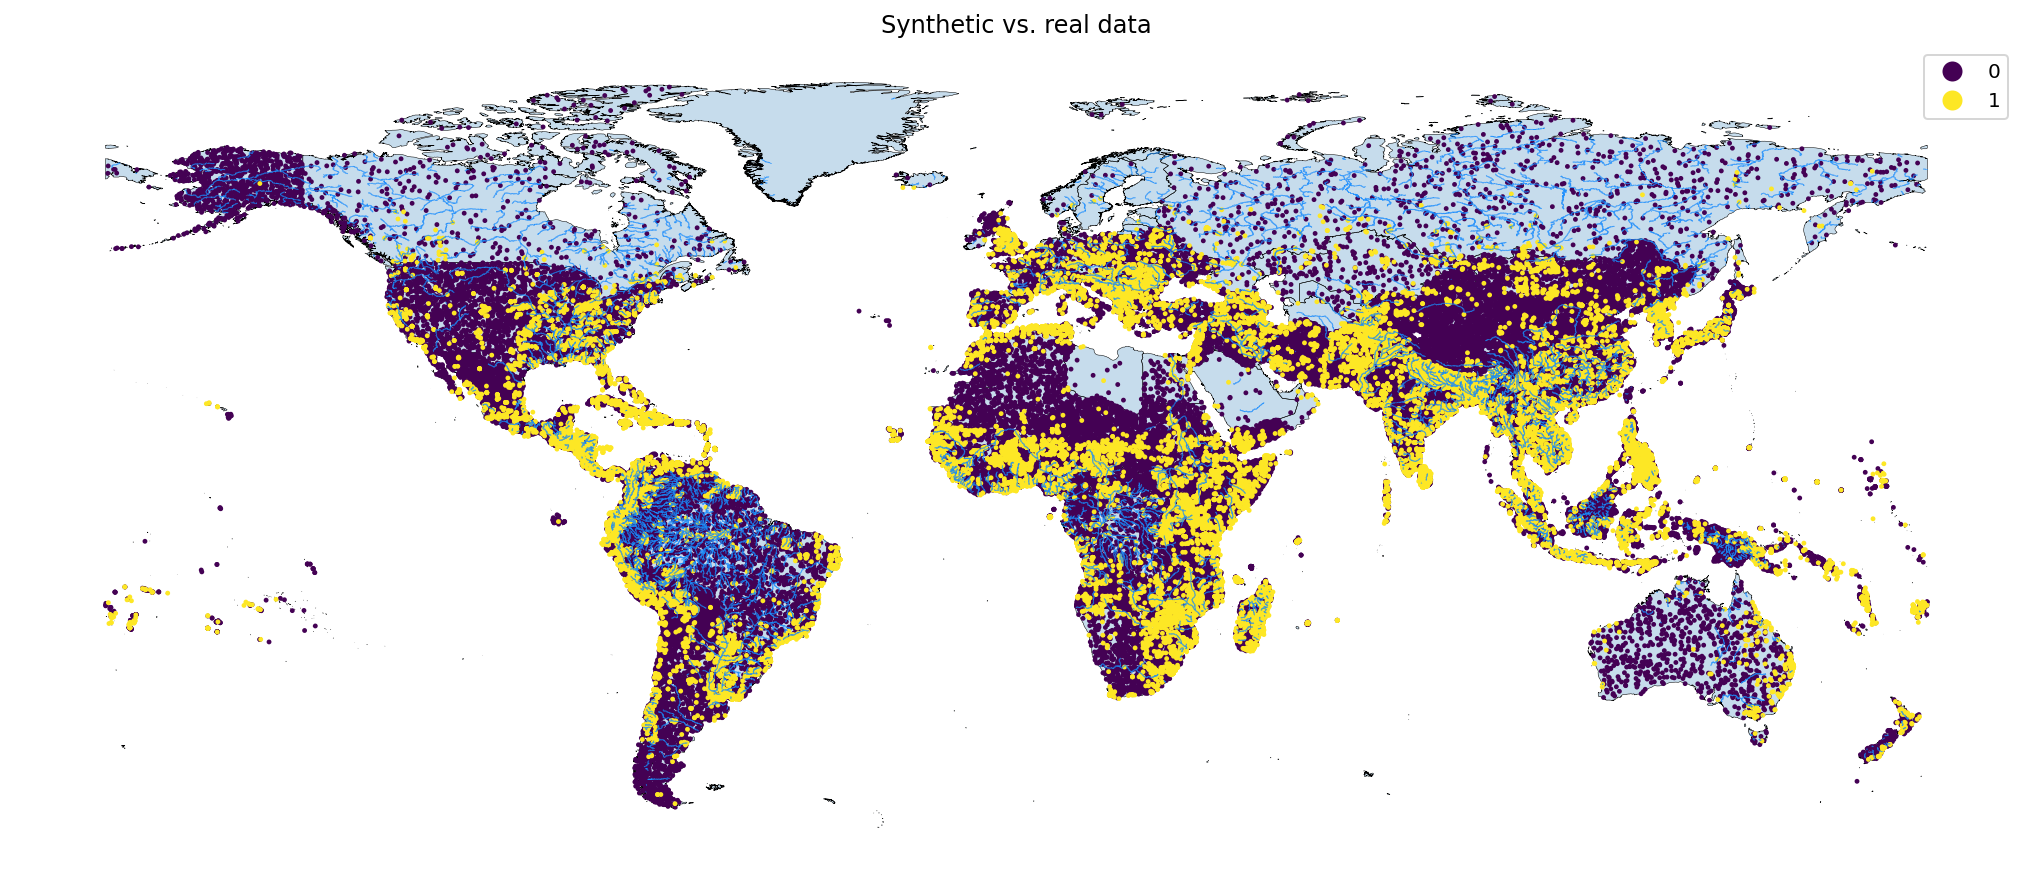

In [28]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

merged_df5.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

We plot the synthetic data for Lao and its neighboors. We observe there is a lack of synthetic data for them

In [29]:
laos_neighboors = ["LAO", "VNM", "KHM", "THA"]
laos_neighboors_df = model_df_4.query('ISO in @laos_neighboors')

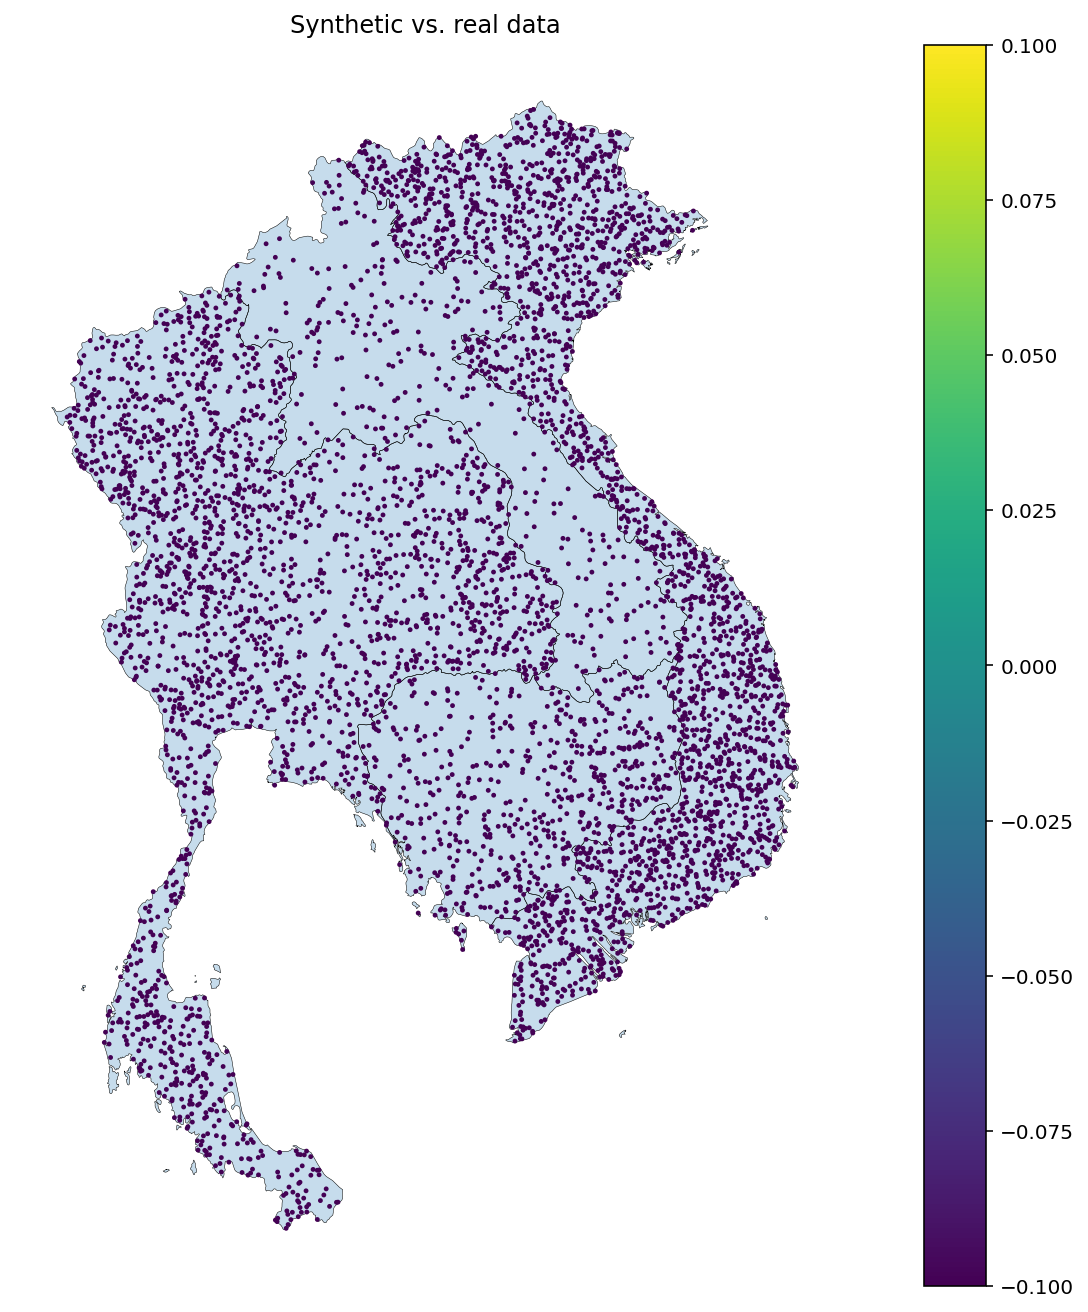

In [30]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

laos_neighboors_df.query('is_disaster == 0').plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [31]:
pd.merge(laos_neighboors_df.query('is_disaster == 0').value_counts("ISO"),
         laos_neighboors_df.query('is_disaster == 1').value_counts("ISO"), left_index=True, right_index=True).rename(
    columns = {"count_x": 'no_disaster', "count_y": "disaster"}
         )

no_disaster  disaster
ISO                       
VNM         2484       828
THA         2310       770
KHM          567       189
LAO          300       100

# Model helper functions

In [32]:
# Standardize function
def standardize(df: pd.DataFrame):
    df_standardized = (df - df.mean())/df.std()
    return df_standardized

In [33]:
#Define data function
def add_data(features: list[str], target: str, df: pd.DataFrame , add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", standardize(df[features]), dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
    return X,Y

#Add country fixed effect function
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
   
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


In [34]:
# Function to create plot inputs
def generate_plot_inputs(idata):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[ "ISO"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO",  "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO",  "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [35]:
#Plotting function
def plotting_function(idata, country: str):
    df_predictions = generate_plot_inputs(idata = idata)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data["is_disaster"], color='k', label='Actual prob')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [36]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

# Creating Laos grid

In [37]:
#Creating Laos grid
lon_min, lat_min, lon_max, lat_max = laos.dissolve().bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [38]:
#Obtain distance with rivers
Laos_distances_rivers = (get_distance_to(rivers, points=laos_points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                  .rename(columns={'distance_to_closest':'distance_to_river'}))

laos_points = pd.merge(laos_points, Laos_distances_rivers, left_index= True, right_index= True, how = "left")

  0%|          | 0/2980 [00:00<?, ?it/s]

In [39]:
#Obtain Laos distance with coastlines
Laos_distances_coastlines = (get_distance_to(coastline.boundary, points=laos_points, return_columns=None)
                              .rename(columns={'distance_to_closest':'distance_to_coastline'}))

laos_points =  pd.merge(laos_points, Laos_distances_coastlines, left_index= True, right_index= True, how = "left")

  0%|          | 0/2980 [00:00<?, ?it/s]

In [40]:
#Assign is_island column
laos_points["is_island"] = False

#Create log of distances
laos_points = laos_points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river)  )

laos_points = laos_points.assign(log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline)  )

# Logistic regression simple version

In [41]:
#Delimiting data set
model_list_1 = ['ISO', 'Start_Year', "is_disaster" ]

model_df_1 = merged_df5[model_list_1].dropna()

In [42]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_1["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_1["ISO"]) 
obs_idx = model_df_1.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_1.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords = {"is_disaster" : is_disaster,
          "obs_idx": obs_idx,
             "ISO": ISO,}


In [43]:
#HydroMeteorological Disasters

with pm.Model(coords=coords) as simple_model1:
    #Declare data
    Y = pm.Data("Y", model_df_1["is_disaster"])
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Model mu
    p = country_effect[ISO_idx] 

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

#Sampling
with simple_model1:
    simple_model1_idata =sample_or_load(
            fp="simple_model1_long_b",
            resample=False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    simple_model1_idata = simple_model1_idata.assign_coords(xr_idx)

effect_exp = scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(simple_model1_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_1.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

plt.hist(scipy.special.expit(simple_model1_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist(np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

# Logistic regression with distance features

#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
                "lat", "long" ]

features_2 = ['log_distance_to_river', 'log_distance_to_coastline']

model_df_2 = merged_df5[model_list_2].dropna()

#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_2["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_2["ISO"]) 
obs_idx = model_df_2.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_2.set_index(['lat', 'long']).index, 'lat_long')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
            "obs_idx": obs_idx,
             "ISO": ISO,
             "feature": features_2,
             "lat": model_df_2["lat"],
                "long": model_df_2["long"],
           }


with pm.Model(coords=coords_2) as model_distance2:
    #Declare data
    X, Y= add_data(features= features_2 ,  target = "is_disaster", df =  model_df_2, )
    is_island = pm.Data("is_island",  model_df_2["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [ 1, 1]
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("is_island_beta", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

#Sampling
with model_distance2:
    model_distance2_idata =sample_or_load(
            fp="model_distance2d",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance2_idata = model_distance2_idata.assign_coords({"lat": model_df_2["lat"],
                                                                 "long": model_df_2["long"]})

plt.hist(scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_1.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

effect_exp = scipy.special.expit(model_distance2_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance2_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_2.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

az.summary(model_distance2_idata, ["~country_effect", "~country_effect_offset"])

az.plot_trace(model_distance2_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

predictions_df_2 = model_distance2_idata.posterior_predictive.mean(dim=['chain', 'draw'])["y_hat"].to_dataframe()
lat_long = model_df_2[["lat", "long", "ISO"]].reset_index().rename(columns = {"index": "obs_idx"}).set_index("obs_idx")

predictions_df_2 = pd.merge(predictions_df_2, lat_long, left_index=True, right_index= True, how = "left" )

#Tranform lat and long to geometry data
predictions_geo_2 = gpd.GeoDataFrame(
                predictions_df_2, geometry=gpd.points_from_xy(predictions_df_2["long"], predictions_df_2["lat"]), crs="EPSG:4326"
            )

## Laos predictions


#Sample predictions for Laos
with pm.Model(coords=coords_2) as model_distance2_plot:
    laos_lat = laos_points["lat"]
    laos_long = laos_points["lon"]
    X = laos_points[['log_distance_to_river', 'log_distance_to_coastline']]
    laos_is_island = laos_points["is_island"]
    
    #country_effect = pm.Flat("country_effect", dims = ["ISO"])
    beta = pm.Flat("beta", dims=["feature"])
    is_island_beta = pm.Flat("is_island_beta")
    country_effect = pm.Flat("country_effect", dims=["ISO"])
    

    point_prediction = pm.Deterministic("point_prediction", country_effect[151] + (beta[0] * X["log_distance_to_river"] ) +
                                        (beta[1] * X["log_distance_to_coastline"] )+ ( is_island_beta * laos_is_island) )

    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_distance2_plot_idata = pm.sample_posterior_predictive(
        model_distance2_idata,
        var_names=[
            "point_probability",
        ]
    )

#Store df of predictions
model_distance2_predictions = (model_distance2_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance2_predictions = pd.merge(model_distance2_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance2_predictions_geo = gpd.GeoDataFrame(
                model_distance2_predictions,
    geometry=gpd.points_from_xy(model_distance2_predictions["lon"], model_distance2_predictions["lat"]), crs="EPSG:4326"
            )

#Create the geodata set for Laos disasters
laos_disasters = model_df_2.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

#Plot the predictions
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Predictions of the probability of disaster for Laos", );

#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("point_probability",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;


#Plot distance to river with actual disasters
fig, ax = plt.subplots()
model_distance2_predictions_geo.plot("log_distance_to_river",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#e8702a")
plt.title("log_distance_to_river plot for Laos", );

# Logistic regression with distance and country features

#Delimiting data set
model_list_3 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long"]

features_3 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_3 = merged_df5[model_list_3].dropna()

#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_3["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_3["ISO"]) 
obs_idx = model_df_3.index

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_3.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_3 = {"is_disaster" : is_disaster,
            "obs_idx": obs_idx,
            "ISO": ISO,
            "feature": features_3,
            "lat": model_df_3["lat"],
            "long": model_df_3["long"],}


with pm.Model(coords=coords_3) as model_distance3:
    #Declare data
    X, Y= add_data(features= features_3 ,  target = "is_disaster", df =  model_df_3, )
    is_island = pm.Data("is_island",  model_df_3["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("is_island_beta", mu = 1, sigma = 1)

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta)

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

#Sampling
with model_distance3:
    model_distance3_idata =sample_or_load(
            fp="model_distance3d",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'numpyro',
                "chains": 8,
                "draws": 1000,
            })

    model_distance3_idata = model_distance3_idata.assign_coords(xr_idx)

az.summary(model_distance3_idata, ["~country_effect", "~country_effect_offset"])

plt.hist(scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_3.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

effect_exp = scipy.special.expit(model_distance3_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance3_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_3.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

## Laos predictions

In [44]:
#Sample predictions for Laos


# with pm.Model(coords=coords_3) as model_distance3_plot:
#     laos_lat = laos_points["lat"]
#     laos_long = laos_points["lon"]
#     X = laos_points[['log_distance_to_river', 'log_distance_to_coastline']]
#     laos_is_island = laos_points["is_island"]
    
#     #country_effect = pm.Flat("country_effect", dims = ["ISO"])
#     beta = pm.Flat("beta", dims=["feature"])
#     is_island_beta = pm.Flat("is_island_beta")
#     country_effect = pm.Flat("country_effect", dims=["ISO"])
    

#     point_prediction = pm.Deterministic("point_prediction", country_effect[ISO_idx] + (beta @ X) + ( is_island_beta * laos_is_island) )

#     point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

#     model_distance3_plot_idata = pm.sample_posterior_predictive(
#         model_distance3_idata,
#         var_names=[
#             "point_probability",
#         ]
#     )

# Losgistic regression with HSGP component

In [45]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long" ]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

In [46]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


## 100% Sample m=15

In [47]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


In [48]:
with pm.Model(coords=coords_4_sample) as model_distance4:
    #Declare data
    X, Y= add_data(features= features_4 ,  target = "is_disaster", df =  model_df_4, )
    is_island = pm.Data("is_island",  model_df_4["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df_4[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [49]:
from pymc.model.transform.optimization import freeze_dims_and_data

if exists("full_sample_m15_long_non-dis_idata.idata"):
    model_distance4_idata = az.from_netcdf("full_sample_m15_long_non-dis_idata.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_distance4), backend="jax", gradient_backend='jax')
    model_distance4_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_distance4_idata = model_distance4_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_distance4_idata, filename= pathlib.Path("full_sample_m15_long_non-dis_idata.idata"))
    

In [50]:
az.summary(model_distance4_idata, var_names=[ 'beta', "is_island_beta", 'eta', 'ell'])

mean     sd  hdi_3%  hdi_97%  \
beta[log_distance_to_river]           -0.246  0.008  -0.262   -0.230   
beta[log_distance_to_coastline]       -0.641  0.012  -0.663   -0.618   
beta[Population]                      -0.055  0.059  -0.159    0.060   
beta[co2]                              0.048  0.014   0.023    0.074   
beta[precip_deviation]                 0.008  0.007  -0.007    0.021   
beta[dev_ocean_temp]                  -0.004  0.007  -0.017    0.009   
beta[log_population_density]          -0.138  0.078  -0.282    0.005   
beta[log_population_density_squared]  -0.136  0.077  -0.275    0.015   
beta[log_gdp_per_cap]                 -0.039  0.075  -0.175    0.109   
beta[log_gdp_per_cap_squared]         -0.039  0.075  -0.180    0.102   
is_island_beta                        -1.732  0.038  -1.802   -1.659   
eta                                   17.664  3.109  12.577   23.629   
ell[lat]                               3.250  0.986   1.546    5.103   
ell[long]                             11.384  3.794   4.581   18.499   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[log_distance_to_river]               0.000    0.000    5611.0    4991.0   
beta[log_distance_to_coastline]           0.000    0.000    5881.0    4911.0   
beta[Population]                          0.001    0.001    9127.0    4403.0   
beta[co2]                                 0.000    0.000    7605.0    5897.0   
beta[precip_deviation]                    0.000    0.000    5623.0    3852.0   
beta[dev_ocean_temp]                      0.000    0.000    5985.0    3977.0   
beta[log_population_density]              0.001    0.001   11829.0    4241.0   
beta[log_population_density_squared]      0.001    0.001   11748.0    4306.0   
beta[log_gdp_per_cap]                     0.001    0.001   11733.0    4060.0   
beta[log_gdp_per_cap_squared]             0.001    0.001   10324.0    3919.0   
is_island_beta                            0.000    0.000    6426.0    5158.0   
eta                                       0.050    0.036    3899.0    4280.0   
ell[lat]                                  0.012    0.009    6360.0    4670.0   
ell[long]                                 0.074    0.054    2664.0    3698.0   

                                      r_hat  
beta[log_distance_to_river]             1.0  
beta[log_distance_to_coastline]         1.0  
beta[Population]                        1.0  
beta[co2]                               1.0  
beta[precip_deviation]                  1.0  
beta[dev_ocean_temp]                    1.0  
beta[log_population_density]            1.0  
beta[log_population_density_squared]    1.0  
beta[log_gdp_per_cap]                   1.0  
beta[log_gdp_per_cap_squared]           1.0  
is_island_beta                          1.0  
eta                                     1.0  
ell[lat]                                1.0  
ell[long]                               1.0

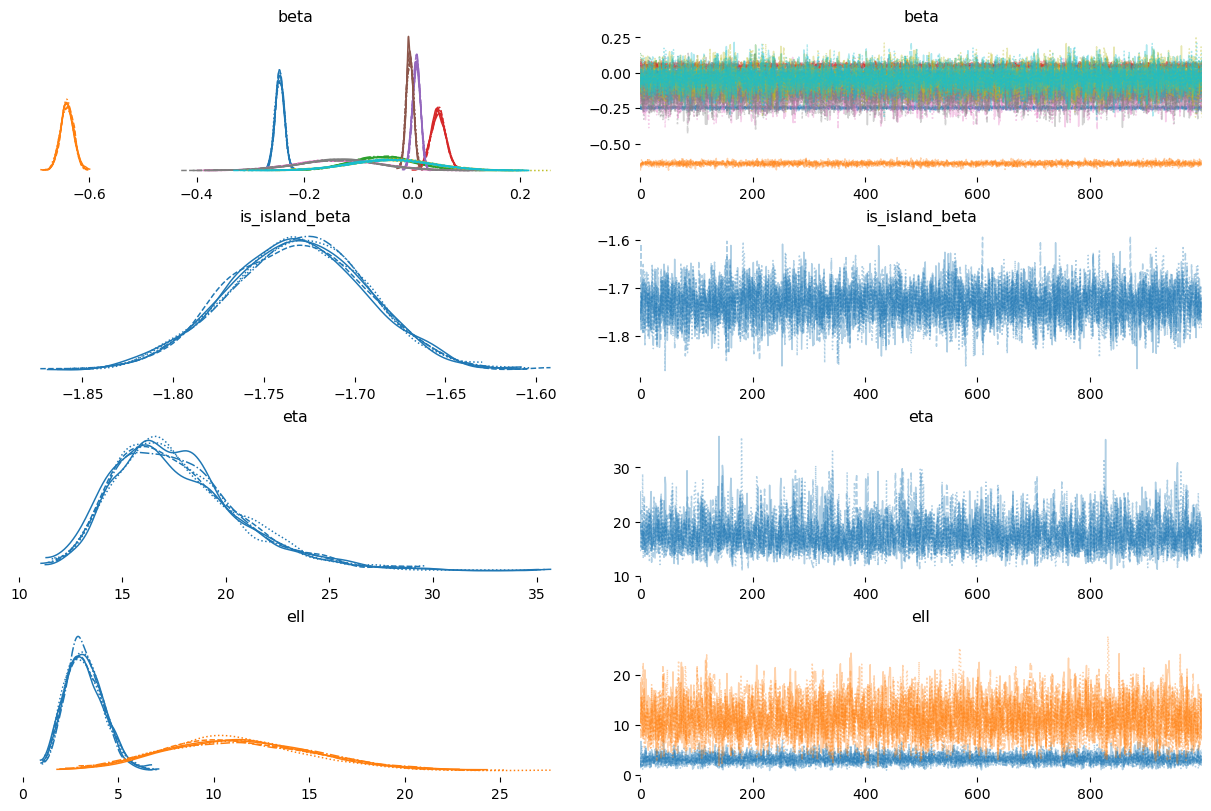

In [51]:
az.plot_trace(model_distance4_idata, var_names=[ 'beta', "is_island_beta", 'eta', 'ell']);

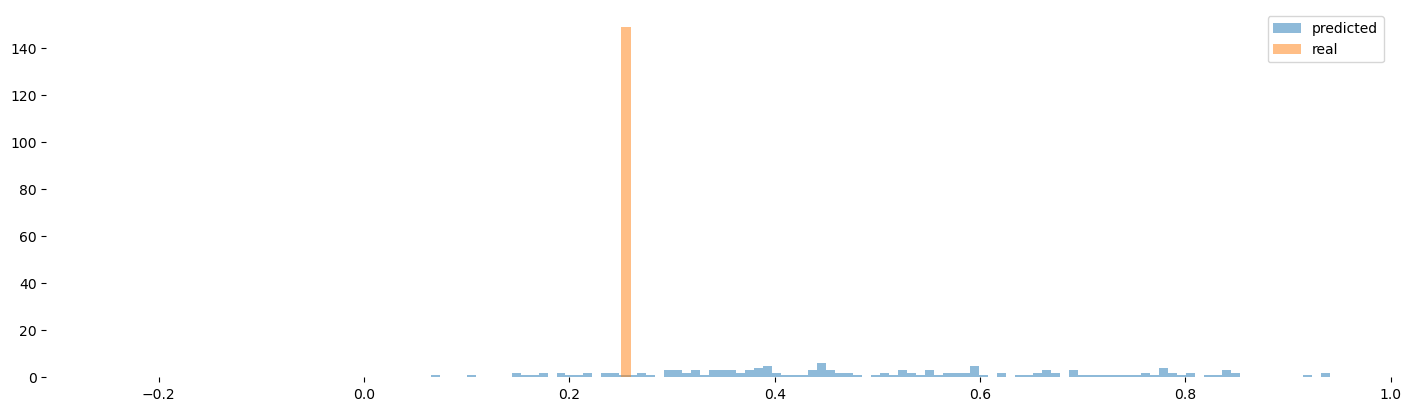

In [52]:
plt.hist(scipy.special.expit(model_distance4_idata.posterior.country_effect).mean(dim =["chain", "draw"]),
         bins = 100, alpha=0.5 , label = "predicted")

plt.hist( np.array(model_df_4.groupby("ISO").is_disaster.mean()), bins = 100,  alpha=0.5, label = "real");

plt.legend();

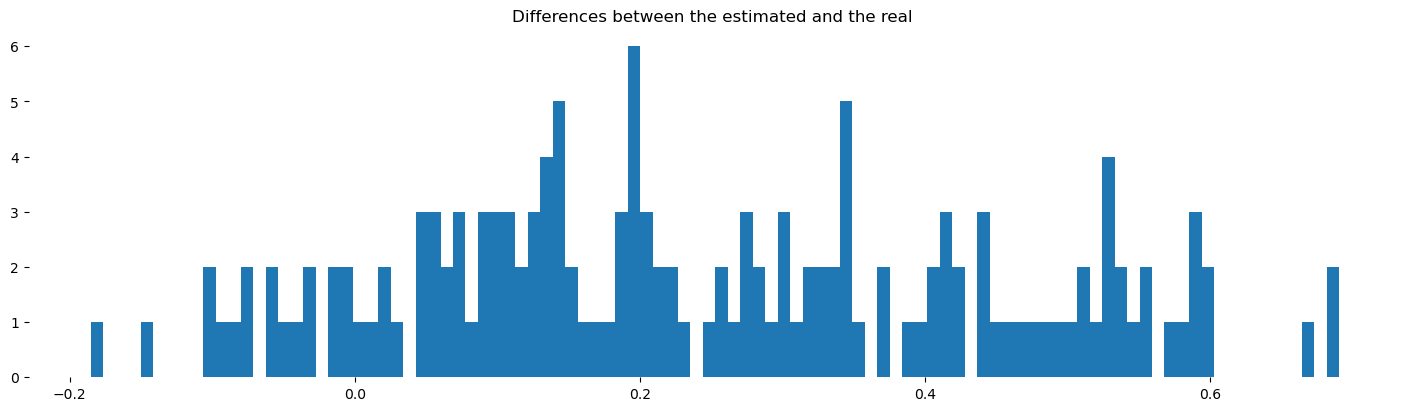

In [53]:
effect_exp = scipy.special.expit(model_distance4_idata.posterior.country_effect).mean(dim =["chain", "draw"])

summary_df = az.summary(model_distance4_idata )["mean"]

differences  = ( effect_exp - np.array(model_df_4.groupby("ISO").is_disaster.mean()) )
plt.hist(differences, bins = 100)
plt.title("Differences between the estimated and the real ");

### Laos prediction

### HSGP component

In [54]:
#HSGP component
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

with pm.Model(coords=coords_4) as HSGP_m_15_plot:
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    f_plot_invlogit = pm.Deterministic('f_plot_invlogit', pm.math.invlogit(f_plot))

    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names=["f_plot","f_plot_invlogit"]
    )
    

Sampling: []


Output()

In [55]:
#Store df of predictions
model_distance_HSGP_predictions = (HSGP_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["f_plot_invlogit"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance_HSGP_predictions = pd.merge(model_distance_HSGP_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance_HSGP_predictions_geo = gpd.GeoDataFrame(
                model_distance_HSGP_predictions,
    geometry=gpd.points_from_xy(model_distance_HSGP_predictions["lon"], model_distance_HSGP_predictions["lat"]), crs="EPSG:4326"
            )



In [56]:
#Create the geodata set for Laos disasters
laos_disasters = model_df_4.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

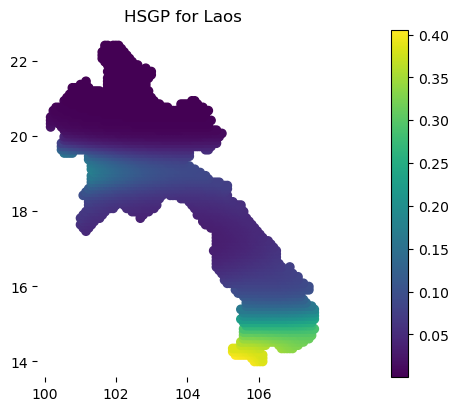

In [57]:
#Plot the predictions
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)
plt.title("HSGP for Laos", );

''

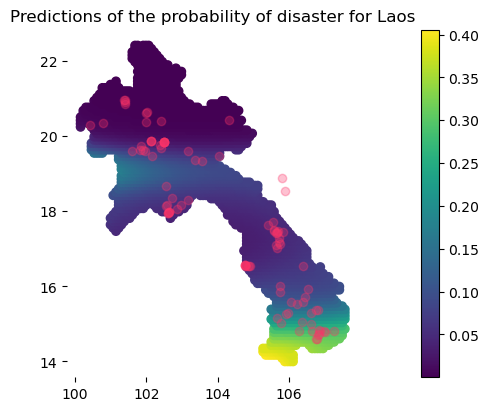

In [58]:
#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;

### Full model predictions

In [59]:
az.summary(model_distance4_idata, var_names=["beta"])

mean     sd  hdi_3%  hdi_97%  \
beta[log_distance_to_river]          -0.246  0.008  -0.262   -0.230   
beta[log_distance_to_coastline]      -0.641  0.012  -0.663   -0.618   
beta[Population]                     -0.055  0.059  -0.159    0.060   
beta[co2]                             0.048  0.014   0.023    0.074   
beta[precip_deviation]                0.008  0.007  -0.007    0.021   
beta[dev_ocean_temp]                 -0.004  0.007  -0.017    0.009   
beta[log_population_density]         -0.138  0.078  -0.282    0.005   
beta[log_population_density_squared] -0.136  0.077  -0.275    0.015   
beta[log_gdp_per_cap]                -0.039  0.075  -0.175    0.109   
beta[log_gdp_per_cap_squared]        -0.039  0.075  -0.180    0.102   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[log_distance_to_river]               0.000    0.000    5611.0    4991.0   
beta[log_distance_to_coastline]           0.000    0.000    5881.0    4911.0   
beta[Population]                          0.001    0.001    9127.0    4403.0   
beta[co2]                                 0.000    0.000    7605.0    5897.0   
beta[precip_deviation]                    0.000    0.000    5623.0    3852.0   
beta[dev_ocean_temp]                      0.000    0.000    5985.0    3977.0   
beta[log_population_density]              0.001    0.001   11829.0    4241.0   
beta[log_population_density_squared]      0.001    0.001   11748.0    4306.0   
beta[log_gdp_per_cap]                     0.001    0.001   11733.0    4060.0   
beta[log_gdp_per_cap_squared]             0.001    0.001   10324.0    3919.0   

                                      r_hat  
beta[log_distance_to_river]             1.0  
beta[log_distance_to_coastline]         1.0  
beta[Population]                        1.0  
beta[co2]                               1.0  
beta[precip_deviation]                  1.0  
beta[dev_ocean_temp]                    1.0  
beta[log_population_density]            1.0  
beta[log_population_density_squared]    1.0  
beta[log_gdp_per_cap]                   1.0  
beta[log_gdp_per_cap_squared]           1.0

In [60]:
#Full model predictions
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

time_varying_features_4 = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']


with pm.Model(coords=coords_4) as full_model_m_15_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    time_varying_features_2020 =(model_df_4.loc[70736,][time_varying_features_4]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                            country_effect[128] 
                            + ( is_island_beta * laos_is_island) 
                            #+ (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
                            + f_plot
                            #+  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    full_model_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names= ["point_probability"]
    )
    

Sampling: []


Output()

In [61]:
#Store df of predictions
full_model_m_15_plot_idata_predictions = (full_model_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
full_model_m_15_plot_idata_predictions = pd.merge(full_model_m_15_plot_idata_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
full_model_m_15_plot_idata_predictions_geo = gpd.GeoDataFrame(
                full_model_m_15_plot_idata_predictions,
    geometry=gpd.points_from_xy(full_model_m_15_plot_idata_predictions["lon"],
                                full_model_m_15_plot_idata_predictions["lat"]),crs="EPSG:4326"
            )



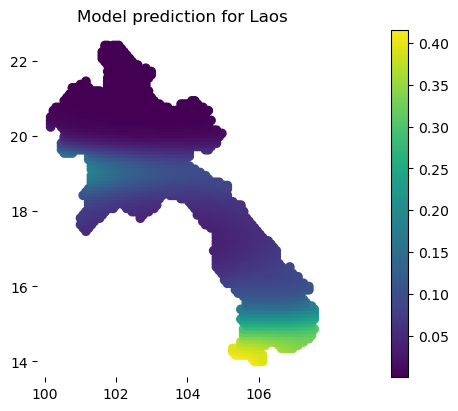

In [62]:
#Plot the predictions
fig, ax = plt.subplots()
full_model_m_15_plot_idata_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Model prediction for Laos", );

''

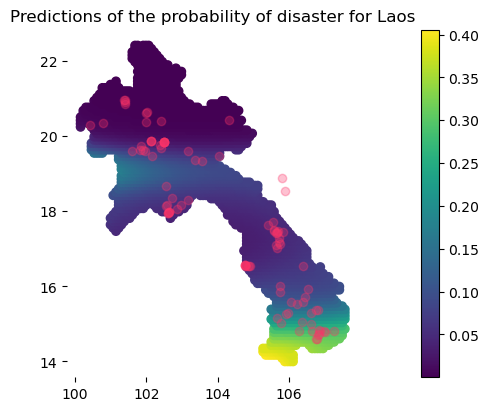

In [63]:
#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;